In [4]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.0 MB/s eta 0:00:0000:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bi

In [5]:
!pip install ultralytics

In [6]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random
from ultralytics import YOLO
import cv2


In [7]:
data_dir = '/kaggle/input/axontest/data'
images_dir = os.path.join(data_dir, 'images')
labels_path = os.path.join(data_dir, 'labels.csv')

working_dir = '/kaggle/working/extracted_dataset'
yolo_labels_dir = os.path.join(working_dir, 'yolo_labels')
train_dir = os.path.join(working_dir, 'train')
val_dir = os.path.join(working_dir, 'val')

os.makedirs(yolo_labels_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)



In [8]:
labels_df = pd.read_csv(labels_path)
print("Loaded labels:")
print(labels_df.head())


Loaded labels:
             image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422


In [9]:
def convert_bbox_to_yolo(xmin, ymin, xmax, ymax, img_width, img_height):
    x_center = ((xmin + xmax) / 2) / img_width
    y_center = ((ymin + ymax) / 2) / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height
    return x_center, y_center, width, height

for _, row in labels_df.iterrows():
    image_name = row['image']
    image_path = os.path.join(images_dir, image_name)

    if not os.path.exists(image_path):
        continue

    with Image.open(image_path) as img:
        img_width, img_height = img.size

    x_center, y_center, width, height = convert_bbox_to_yolo(
        row['xmin'], row['ymin'], row['xmax'], row['ymax'], img_width, img_height
    )

    yolo_file_path = os.path.join(yolo_labels_dir, image_name.replace('.jpg', '.txt'))
    with open(yolo_file_path, 'a') as yolo_file:
        yolo_file.write(f"0 {x_center} {y_center} {width} {height}\n")



In [10]:
all_images = os.listdir(images_dir)
random.shuffle(all_images)

split_ratio = 0.8
train_size = int(len(all_images) * split_ratio)
train_images = all_images[:train_size]
val_images = all_images[train_size:]

def move_files(image_list, target_img_dir, target_lbl_dir):
    for img_file in image_list:
        src_img_path = os.path.join(images_dir, img_file)
        src_lbl_path = os.path.join(yolo_labels_dir, img_file.replace('.jpg', '.txt'))

        dst_img_path = os.path.join(target_img_dir, img_file)
        dst_lbl_path = os.path.join(target_lbl_dir, img_file.replace('.jpg', '.txt'))

        shutil.copy(src_img_path, dst_img_path)

        if os.path.exists(src_lbl_path):
            shutil.copy(src_lbl_path, dst_lbl_path)

move_files(train_images, os.path.join(train_dir, 'images'), os.path.join(train_dir, 'labels'))
move_files(val_images, os.path.join(val_dir, 'images'), os.path.join(val_dir, 'labels'))

train_image_count = len(os.listdir(os.path.join(train_dir, 'images')))
val_image_count = len(os.listdir(os.path.join(val_dir, 'images')))
print(f"Train images: {train_image_count}, Validation images: {val_image_count}")



Train images: 800, Validation images: 201


In [11]:
yolo_config_content = f"""
train: {train_dir}/images
val: {val_dir}/images

nc: 1
names: ['car']
"""

yolo_config_path = os.path.join(working_dir, 'yolo_config.yaml')
with open(yolo_config_path, 'w') as config_file:
    config_file.write(yolo_config_content)

print("YOLO config path:", yolo_config_path)



YOLO config path: /kaggle/working/extracted_dataset/yolo_config.yaml


In [12]:
model = YOLO("yolov8n.pt")
results = model.train(data=yolo_config_path, epochs=25, imgsz=640)


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.3MB/s]


Ultralytics 8.3.24 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/extracted_dataset/yolo_config.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

100%|██████████| 755k/755k [00:00<00:00, 13.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 61.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/extracted_dataset/train/labels... 282 images, 518 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<00:00, 1429.51it/s]

train: New cache created: /kaggle/working/extracted_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/extracted_dataset/val/labels... 73 images, 128 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<00:00, 1469.98it/s]

val: New cache created: /kaggle/working/extracted_dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25       2.2G      1.431       3.11       1.16          9        640: 100%|██████████| 50/50 [00:09<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        201        126    0.00206      0.984     0.0181     0.0113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.14G      1.398      2.189       1.18         23        640: 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]

                   all        201        126      0.958      0.722      0.901      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.14G      1.407      1.737       1.17         18        640: 100%|██████████| 50/50 [00:08<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


                   all        201        126      0.936      0.897      0.957      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.14G      1.416      1.419      1.198         15        640: 100%|██████████| 50/50 [00:08<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


                   all        201        126      0.955      0.929      0.977      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.14G      1.398      1.215       1.17          4        640: 100%|██████████| 50/50 [00:08<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]

                   all        201        126      0.937      0.921      0.968       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.14G      1.365      1.071      1.155         23        640: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


                   all        201        126      0.953      0.944      0.979      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.13G      1.351     0.9638      1.146         19        640: 100%|██████████| 50/50 [00:07<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]

                   all        201        126      0.949      0.857      0.944      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.13G      1.302     0.8936      1.126         19        640: 100%|██████████| 50/50 [00:08<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]

                   all        201        126      0.982      0.913      0.979      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.13G       1.29     0.8479      1.137         21        640: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


                   all        201        126      0.965      0.937      0.973      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.13G      1.244     0.7918      1.117         22        640: 100%|██████████| 50/50 [00:07<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.77it/s]

                   all        201        126      0.968       0.96      0.988      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.15G      1.261     0.7732      1.115         18        640: 100%|██████████| 50/50 [00:08<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.38it/s]

                   all        201        126      0.953      0.968      0.986      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      2.15G      1.249     0.7454       1.12         15        640: 100%|██████████| 50/50 [00:08<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]

                   all        201        126      0.953      0.956      0.985      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.13G      1.234     0.7536      1.097          9        640: 100%|██████████| 50/50 [00:08<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]

                   all        201        126      0.945      0.957       0.98      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.13G      1.214     0.7112      1.103         11        640: 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.35it/s]

                   all        201        126      0.945      0.937       0.98      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.13G      1.182     0.6731      1.078         25        640: 100%|██████████| 50/50 [00:07<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.99it/s]

                   all        201        126      0.933      0.984      0.985      0.683


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.13G      1.201      0.685      1.097          5        640: 100%|██████████| 50/50 [00:09<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.31it/s]

                   all        201        126      0.953      0.975      0.971      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.13G      1.178      0.659      1.096         12        640: 100%|██████████| 50/50 [00:07<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


                   all        201        126      0.945      0.963      0.981      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.13G      1.184     0.6722      1.094          5        640: 100%|██████████| 50/50 [00:07<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.27it/s]

                   all        201        126      0.951      0.976      0.981       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.13G      1.141      0.637      1.091          8        640: 100%|██████████| 50/50 [00:07<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]

                   all        201        126      0.938      0.976      0.983      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.13G      1.128     0.6515      1.091         11        640: 100%|██████████| 50/50 [00:07<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.57it/s]

                   all        201        126      0.952      0.984      0.984        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.13G      1.102     0.6408      1.058          7        640: 100%|██████████| 50/50 [00:07<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.04it/s]

                   all        201        126      0.955      0.976      0.984      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.13G      1.112     0.5874      1.068          7        640: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.07it/s]

                   all        201        126      0.957      0.984      0.984      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.13G      1.108     0.5673      1.055         14        640: 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.49it/s]

                   all        201        126      0.961      0.979      0.984      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.13G      1.077     0.5658      1.044          2        640: 100%|██████████| 50/50 [00:07<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.30it/s]

                   all        201        126      0.946      0.984      0.984      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.13G      1.047     0.5663      1.013          6        640: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.56it/s]

                   all        201        126      0.954      0.984      0.985       0.71



25 epochs completed in 0.069 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.24 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


                   all        201        126      0.954      0.984      0.985       0.71
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train



image 1/1 /kaggle/working/extracted_dataset/val/images/vid_4_12060.jpg: 384x640 1 car, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


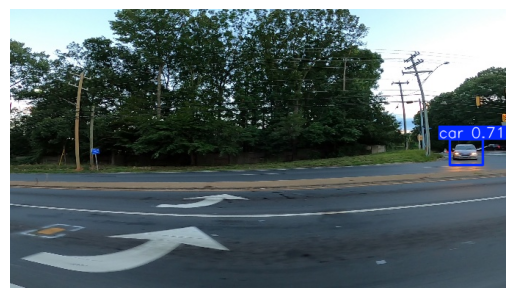

In [15]:
sample_image_path = os.path.join(val_dir, 'images', 'vid_4_12060.jpg')
results = model(sample_image_path)

predicted_image = results[0].plot()
predicted_image_rgb = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image_rgb)
plt.axis('off')
plt.show()


## Рекомендации по улучшению

- Увеличить датасет
- Увеличить количество эпох обучения модели
- Попробовать использовать более крупные модели YOLO (хотя ранее в проектах это не сильно помогало, только увеличивало время обучения)

Также в задании указано "возвращать маску наложенную на изображение (изображения)", но датасет не размечен под сегментацию, поэтому закрашивается прямоугольная область.

Пример с сегментацией ниже. 

## Тестирование YOLO8-seg


0: 384x640 1 car, 54.1ms
Speed: 2.1ms preprocess, 54.1ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)


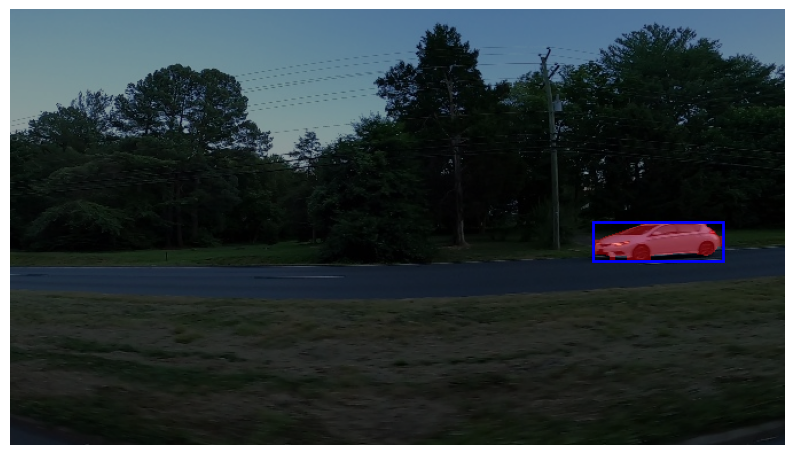

Bounding Box Coordinates: [(508, 185, 621, 219)]


In [16]:
import cv2
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt

model = YOLO('yolov8n-seg.pt')

def detect_and_segment(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image_rgb.shape[:2]

    results = model(image_rgb)

    detected_objects = results[0]

    if detected_objects.boxes is None or detected_objects.masks is None:
        print("No objects detected.")
        plt.imshow(image_rgb)
        plt.axis("off")
        plt.show()
        return []

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image_rgb)
    bbox_coordinates = []

    for idx, (box, mask, class_id) in enumerate(zip(detected_objects.boxes.xyxy, 
                                                     detected_objects.masks.data, 
                                                     detected_objects.boxes.cls)):
        if int(class_id) != 2:
            continue

        xmin, ymin, xmax, ymax = map(int, box)

        bbox_coordinates.append((xmin, ymin, xmax, ymax))

        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                   linewidth=2, edgecolor='blue', facecolor='none'))

        mask_np = mask.cpu().numpy().astype(np.uint8) * 255  
        mask_resized = cv2.resize(mask_np, (img_width, img_height))

        colored_mask = np.zeros_like(image_rgb)
        colored_mask[mask_resized == 255] = [255, 0, 0]
        overlay = cv2.addWeighted(image_rgb, 0.6, colored_mask, 0.4, 0)
        ax.imshow(overlay)

    plt.axis("off")
    plt.show()
    
    return bbox_coordinates

image_path = '/kaggle/input/axontest/data/images/vid_4_10020.jpg'

bbox_coordinates = detect_and_segment(image_path)

print("Bounding Box Coordinates:", bbox_coordinates)
